In [2]:
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
import pandas as pd
import math
import joblib
# %run 3.Xfoil_runner_extract_value.ipynb

In [3]:
x1 = pd.read_excel('design_parmeter.xlsx')
y1 = pd.read_excel('Cl_Cd.xlsx')

In [4]:
df = pd.merge(x1, y1)
df = df.dropna()
df

,Unnamed: 0,x1,x2,x3,x4,x5,x6,x7,x8,CL,CD
0,0,0.0084,0.0104,-0.0033,-0.0033,-0.0086,0.0015,-0.0019,-0.0027,0.5294,0.00733
1,1,-0.0045,-0.0035,0.0057,0.0062,0.0106,-0.0060,0.0101,0.0037,0.6747,0.00947
2,2,-0.0093,0.0038,-0.0083,-0.0113,0.0030,-0.0028,-0.0093,0.0085,0.4693,0.00959
3,3,0.0019,-0.0093,0.0067,0.0025,-0.0012,0.0077,0.0026,-0.0092,0.5034,0.00928
4,4,0.0045,0.0017,0.0026,0.0050,-0.0039,0.0034,-0.0087,0.0105,0.6249,0.00916
...,...,...,...,...,...,...,...,...,...,...,...
251,251,0.0044,-0.0050,-0.0113,-0.0064,0.0019,-0.0010,0.0099,0.0082,0.5649,0.00824
252,252,0.0021,0.0065,-0.0034,-0.0102,0.0045,-0.0120,-0.0044,-0.0066,0.4281,0.00764
253,253,-0.0093,-0.0013,0.0056,0.0013,-0.0027,0.0045,0.0081,0.0118,0.6392,0.01037
254,254,-0.0044,0.0003,-0.0089,-0.0052,-0.0072,0.0103,-0.0088,0.0000,0.4434,0.00834


In [5]:
len(df)

242

In [6]:
X = df[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'] ]
y = df[['CL', 'CD'] ]

In [7]:
X

,x1,x2,x3,x4,x5,x6,x7,x8
0,0.0084,0.0104,-0.0033,-0.0033,-0.0086,0.0015,-0.0019,-0.0027
1,-0.0045,-0.0035,0.0057,0.0062,0.0106,-0.0060,0.0101,0.0037
2,-0.0093,0.0038,-0.0083,-0.0113,0.0030,-0.0028,-0.0093,0.0085
3,0.0019,-0.0093,0.0067,0.0025,-0.0012,0.0077,0.0026,-0.0092
4,0.0045,0.0017,0.0026,0.0050,-0.0039,0.0034,-0.0087,0.0105
...,...,...,...,...,...,...,...,...
251,0.0044,-0.0050,-0.0113,-0.0064,0.0019,-0.0010,0.0099,0.0082
252,0.0021,0.0065,-0.0034,-0.0102,0.0045,-0.0120,-0.0044,-0.0066
253,-0.0093,-0.0013,0.0056,0.0013,-0.0027,0.0045,0.0081,0.0118
254,-0.0044,0.0003,-0.0089,-0.0052,-0.0072,0.0103,-0.0088,0.0000


In [8]:
y

,CL,CD
0,0.5294,0.00733
1,0.6747,0.00947
2,0.4693,0.00959
3,0.5034,0.00928
4,0.6249,0.00916
...,...,...
251,0.5649,0.00824
252,0.4281,0.00764
253,0.6392,0.01037
254,0.4434,0.00834


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import KFold

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

In [25]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = tf.where(tf.equal(y_true, 0.0), 1e-10, y_true)
    ape = tf.abs((y_true - y_pred) / y_true)*100
    ape = tf.where(tf.math.is_finite(ape), ape, 0.0)
    mape = tf.reduce_mean(ape)
    
    return mape

In [26]:
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [97]:
def cal_mape(X,y, model):
    predictions = model.predict(X)
    y = y = np.array(y)
    absolute_errors = np.abs(predictions - y)
    percentage_errors = (absolute_errors / np.abs(y)) * 100
    mape_Cl = np.mean(percentage_errors[:, 0])  
    mape_Cd = np.mean(percentage_errors[:, 1]) 
    return mape_Cl, mape_Cd

In [194]:
def KFOLD_CROSS_VAL(X, y, n_fold, neurons ,activation, loss_func, epoch, batch_size):
    kf = KFold(n_splits=n_fold, shuffle=True)
    num_rows = 0
    num_cols = 4
    loss_score = np.empty((num_rows, num_cols))
    
    for train_index, val_index in kf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        scaler = StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)
        
        from tensorflow.keras.optimizers import Adam
        optimizer = Adam(learning_rate=0.01)
        
        model = Sequential()
        model.add(Dense(neurons, input_dim=8, activation=activation, kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dense(2, activation='linear'))
        model.compile(loss=loss_func, optimizer=optimizer, metrics=['mse',tf.keras.metrics.RootMeanSquaredError(name='rmse'),'mape'])
        model.fit(X_train_fold, y_train_fold, epochs= epoch, batch_size= batch_size)
        
        # Evaluate the model
        loss = model.evaluate(X_val_fold, y_val_fold)
        loss_score = np.vstack([loss_score, np.array(loss)])
    
    # Calculate average accuracy and other metrics if needed
    average_loss = np.mean(loss_score, axis=0)
    return loss_score, average_loss

In [232]:
def ANN_model(X, y, neurons ,activation, loss_func, epoch, batch_size, validation_split):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    from tensorflow.keras.optimizers import Adam
    optimizer = Adam(learning_rate=0.01)
    
    model = Sequential()
    model.add(Dense(neurons, input_dim=8, activation=activation, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(2, activation='linear'))
    model.compile(loss= loss_func, optimizer=optimizer, metrics=['mse',tf.keras.metrics.RootMeanSquaredError(name='rmse'),'mape'])
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_split=validation_split)
    loss = model.evaluate(X_test, y_test)

    cl_train, cd_train = cal_mape(X_train,y_train, model)
    cl_test, cd_test = cal_mape(X_test,y_test, model)
    return model, scaler, loss, history, cl_train, cd_train, cl_test, cd_test

In [127]:
def Validation_curves(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [158]:
n_fold = 5
# neurons_list = [4,6,8,10,12,14,16]
activation = 'tanh'
loss_func = 'mean_absolute_error'
epoch = 200
batch_size = 16
mae= []
mse = []
RMSE = []
mape = []

In [159]:
loss_score, average_loss = KFOLD_CROSS_VAL(X, y, n_fold, 2 ,activation, loss_func, epoch, batch_size)
mae.append(average_loss[0])
mse.append(average_loss[1])
RMSE.append(average_loss[2])
mape.append(average_loss[3])
average_loss

Epoch 1/200
13/13 [==============================] - 1s 2ms/step - loss: 0.4598 - mse: 0.2760 - root_mean_squared_error: 0.5060 - mape: 1903.7866
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 0.2805 - mse: 0.0995 - root_mean_squared_error: 0.3056 - mape: 1079.2925
Epoch 3/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1689 - mse: 0.0300 - root_mean_squared_error: 0.1665 - mape: 650.1097
Epoch 4/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1166 - mse: 0.0120 - root_mean_squared_error: 0.1047 - mape: 475.2124
Epoch 5/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1077 - mse: 0.0097 - root_mean_squared_error: 0.0978 - mape: 452.8513
Epoch 6/200
13/13 [==============================] - 0s 3ms/step - loss: 0.0879 - mse: 0.0059 - root_mean_squared_error: 0.0774 - mape: 332.9652
Epoch 7/200
13/13 [==============================] - 0s 3ms/step - loss: 0.0771 - mse: 0.0041 - root_mean_squared_error: 0.0596 

array([1.12520453e-02, 3.50141473e-04, 1.82174336e-02, 9.36947660e+00])

In [160]:
loss_score, average_loss = KFOLD_CROSS_VAL(X, y, n_fold, 4 ,activation, loss_func, epoch, batch_size)
mae.append(average_loss[0])
mse.append(average_loss[1])
RMSE.append(average_loss[2])
mape.append(average_loss[3])
average_loss

Epoch 1/200
13/13 [==============================] - 1s 2ms/step - loss: 0.3857 - mse: 0.2455 - root_mean_squared_error: 0.4632 - mape: 818.3333
Epoch 2/200
13/13 [==============================] - 0s 2ms/step - loss: 0.2094 - mse: 0.0729 - root_mean_squared_error: 0.2486 - mape: 338.5757
Epoch 3/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0948 - mse: 0.0118 - root_mean_squared_error: 0.0999 - mape: 122.2708
Epoch 4/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0786 - mse: 0.0084 - root_mean_squared_error: 0.0954 - mape: 55.9093
Epoch 5/200
13/13 [==============================] - 0s 3ms/step - loss: 0.0597 - mse: 0.0050 - root_mean_squared_error: 0.0651 - mape: 40.5047
Epoch 6/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0500 - mse: 0.0035 - root_mean_squared_error: 0.0548 - mape: 32.2163
Epoch 7/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0441 - mse: 0.0030 - root_mean_squared_error: 0.0498 - map

array([1.08830120e-02, 3.45541898e-04, 1.81509109e-02, 9.15938721e+00])

In [161]:
loss_score, average_loss = KFOLD_CROSS_VAL(X, y, n_fold, 6 ,activation, loss_func, epoch, batch_size)
mae.append(average_loss[0])
mse.append(average_loss[1])
RMSE.append(average_loss[2])
mape.append(average_loss[3])
average_loss

Epoch 1/200
13/13 [==============================] - 1s 2ms/step - loss: 0.6294 - mse: 0.5207 - root_mean_squared_error: 0.6947 - mape: 2748.1130
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 0.3419 - mse: 0.1489 - root_mean_squared_error: 0.3656 - mape: 1417.5457
Epoch 3/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1846 - mse: 0.0392 - root_mean_squared_error: 0.1864 - mape: 825.2231
Epoch 4/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1006 - mse: 0.0103 - root_mean_squared_error: 0.0929 - mape: 447.8927
Epoch 5/200
13/13 [==============================] - 0s 3ms/step - loss: 0.0911 - mse: 0.0083 - root_mean_squared_error: 0.0890 - mape: 396.0519
Epoch 6/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0735 - mse: 0.0055 - root_mean_squared_error: 0.0702 - mape: 308.8560
Epoch 7/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0616 - mse: 0.0040 - root_mean_squared_error: 0.0596 

array([1.17599754e-02, 4.02084779e-04, 1.92558721e-02, 1.01852545e+01])

In [162]:
loss_score, average_loss = KFOLD_CROSS_VAL(X, y, n_fold, 8 ,activation, loss_func, epoch, batch_size)
mae.append(average_loss[0])
mse.append(average_loss[1])
RMSE.append(average_loss[2])
mape.append(average_loss[3])
average_loss

Epoch 1/200
13/13 [==============================] - 1s 2ms/step - loss: 0.6044 - mse: 0.4654 - root_mean_squared_error: 0.6486 - mape: 2500.1907
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 0.2827 - mse: 0.0832 - root_mean_squared_error: 0.2627 - mape: 943.4500
Epoch 3/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1727 - mse: 0.0223 - root_mean_squared_error: 0.1451 - mape: 711.5315
Epoch 4/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1495 - mse: 0.0162 - root_mean_squared_error: 0.1241 - mape: 556.6343
Epoch 5/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1173 - mse: 0.0101 - root_mean_squared_error: 0.1047 - mape: 454.3583
Epoch 6/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0954 - mse: 0.0061 - root_mean_squared_error: 0.0744 - mape: 333.8819
Epoch 7/200
13/13 [==============================] - 0s 3ms/step - loss: 0.0848 - mse: 0.0050 - root_mean_squared_error: 0.0712 -

array([1.10984495e-02, 3.34005721e-04, 1.80077005e-02, 8.81781359e+00])

In [163]:
loss_score, average_loss = KFOLD_CROSS_VAL(X, y, n_fold, 10 ,activation, loss_func, epoch, batch_size)
mae.append(average_loss[0])
mse.append(average_loss[1])
RMSE.append(average_loss[2])
mape.append(average_loss[3])
average_loss

Epoch 1/200
13/13 [==============================] - 1s 3ms/step - loss: 0.6418 - mse: 0.5180 - root_mean_squared_error: 0.6982 - mape: 2377.3774
Epoch 2/200
13/13 [==============================] - 0s 2ms/step - loss: 0.3188 - mse: 0.1043 - root_mean_squared_error: 0.3080 - mape: 960.4037
Epoch 3/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1893 - mse: 0.0268 - root_mean_squared_error: 0.1548 - mape: 639.0005
Epoch 4/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1484 - mse: 0.0144 - root_mean_squared_error: 0.1127 - mape: 515.2130
Epoch 5/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1303 - mse: 0.0116 - root_mean_squared_error: 0.1086 - mape: 496.5219
Epoch 6/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1139 - mse: 0.0091 - root_mean_squared_error: 0.0901 - mape: 452.6566
Epoch 7/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0995 - mse: 0.0068 - root_mean_squared_error: 0.0806 -

array([1.19043978e-02, 4.10324289e-04, 1.97975732e-02, 7.63952503e+00])

In [164]:
loss_score, average_loss = KFOLD_CROSS_VAL(X, y, n_fold, 12 ,activation, loss_func, epoch, batch_size)
mae.append(average_loss[0])
mse.append(average_loss[1])
RMSE.append(average_loss[2])
mape.append(average_loss[3])
average_loss

Epoch 1/200
13/13 [==============================] - 1s 2ms/step - loss: 0.5603 - mse: 0.3887 - root_mean_squared_error: 0.5950 - mape: 2343.5117
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 0.2277 - mse: 0.0398 - root_mean_squared_error: 0.1882 - mape: 810.5518
Epoch 3/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1953 - mse: 0.0274 - root_mean_squared_error: 0.1562 - mape: 727.3839
Epoch 4/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1478 - mse: 0.0140 - root_mean_squared_error: 0.1141 - mape: 514.5812
Epoch 5/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1349 - mse: 0.0114 - root_mean_squared_error: 0.1002 - mape: 423.4863
Epoch 6/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1084 - mse: 0.0072 - root_mean_squared_error: 0.0898 - mape: 321.4986
Epoch 7/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0977 - mse: 0.0056 - root_mean_squared_error: 0.0711 -

array([1.08139122e-02, 3.32115710e-04, 1.70451269e-02, 6.97704201e+00])

In [165]:
loss_score, average_loss = KFOLD_CROSS_VAL(X, y, n_fold, 14 ,activation, loss_func, epoch, batch_size)
mae.append(average_loss[0])
mse.append(average_loss[1])
RMSE.append(average_loss[2])
mape.append(average_loss[3])
average_loss

Epoch 1/200
13/13 [==============================] - 1s 2ms/step - loss: 0.5778 - mse: 0.3576 - root_mean_squared_error: 0.5516 - mape: 3127.7036
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 0.2593 - mse: 0.0544 - root_mean_squared_error: 0.2352 - mape: 1172.2390
Epoch 3/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1860 - mse: 0.0202 - root_mean_squared_error: 0.1372 - mape: 617.8639
Epoch 4/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1471 - mse: 0.0126 - root_mean_squared_error: 0.1120 - mape: 410.1818
Epoch 5/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1309 - mse: 0.0101 - root_mean_squared_error: 0.1001 - mape: 380.8315
Epoch 6/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1119 - mse: 0.0071 - root_mean_squared_error: 0.0819 - mape: 351.4273
Epoch 7/200
13/13 [==============================] - 0s 3ms/step - loss: 0.0926 - mse: 0.0046 - root_mean_squared_error: 0.0644 

array([1.14709815e-02, 3.15475964e-04, 1.73501227e-02, 1.11761182e+01])

In [166]:
loss_score, average_loss = KFOLD_CROSS_VAL(X, y, n_fold, 16 ,activation, loss_func, epoch, batch_size)
mae.append(average_loss[0])
mse.append(average_loss[1])
RMSE.append(average_loss[2])
mape.append(average_loss[3])
average_loss

Epoch 1/200
13/13 [==============================] - 1s 2ms/step - loss: 0.5714 - mse: 0.3871 - root_mean_squared_error: 0.5657 - mape: 2400.3157
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 0.2216 - mse: 0.0331 - root_mean_squared_error: 0.1702 - mape: 686.5360
Epoch 3/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1592 - mse: 0.0118 - root_mean_squared_error: 0.1025 - mape: 501.4009
Epoch 4/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1324 - mse: 0.0080 - root_mean_squared_error: 0.0858 - mape: 396.1186
Epoch 5/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1108 - mse: 0.0059 - root_mean_squared_error: 0.0732 - mape: 274.2728
Epoch 6/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1011 - mse: 0.0054 - root_mean_squared_error: 0.0681 - mape: 346.5135
Epoch 7/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0986 - mse: 0.0059 - root_mean_squared_error: 0.0703 -

array([1.12485351e-02, 3.22787420e-04, 1.74375230e-02, 8.48819437e+00])

In [167]:
loss_score, average_loss = KFOLD_CROSS_VAL(X, y, n_fold, 18 ,activation, loss_func, epoch, batch_size)
mae.append(average_loss[0])
mse.append(average_loss[1])
RMSE.append(average_loss[2])
mape.append(average_loss[3])
average_loss

Epoch 1/200
13/13 [==============================] - 1s 4ms/step - loss: 0.5453 - mse: 0.3434 - root_mean_squared_error: 0.5136 - mape: 2471.5090
Epoch 2/200
13/13 [==============================] - 0s 4ms/step - loss: 0.2463 - mse: 0.0339 - root_mean_squared_error: 0.1822 - mape: 936.9620
Epoch 3/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1853 - mse: 0.0166 - root_mean_squared_error: 0.1236 - mape: 595.3221
Epoch 4/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1758 - mse: 0.0165 - root_mean_squared_error: 0.1186 - mape: 641.8876
Epoch 5/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1367 - mse: 0.0092 - root_mean_squared_error: 0.0914 - mape: 426.0688
Epoch 6/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1284 - mse: 0.0085 - root_mean_squared_error: 0.0865 - mape: 449.6219
Epoch 7/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1142 - mse: 0.0071 - root_mean_squared_error: 0.0817 -

array([1.21339384e-02, 3.56024626e-04, 1.85882861e-02, 8.91840420e+00])

In [168]:
loss_score, average_loss = KFOLD_CROSS_VAL(X, y, n_fold, 20 ,activation, loss_func, epoch, batch_size)
mae.append(average_loss[0])
mse.append(average_loss[1])
RMSE.append(average_loss[2])
mape.append(average_loss[3])
average_loss

Epoch 1/200
13/13 [==============================] - 1s 2ms/step - loss: 0.6217 - mse: 0.4831 - root_mean_squared_error: 0.6392 - mape: 2022.2383
Epoch 2/200
13/13 [==============================] - 0s 2ms/step - loss: 0.2437 - mse: 0.0403 - root_mean_squared_error: 0.2006 - mape: 693.4930
Epoch 3/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1786 - mse: 0.0150 - root_mean_squared_error: 0.1176 - mape: 620.4487
Epoch 4/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1562 - mse: 0.0125 - root_mean_squared_error: 0.1131 - mape: 602.7255
Epoch 5/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1337 - mse: 0.0087 - root_mean_squared_error: 0.0916 - mape: 422.5678
Epoch 6/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1178 - mse: 0.0074 - root_mean_squared_error: 0.0816 - mape: 428.8153
Epoch 7/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0925 - mse: 0.0040 - root_mean_squared_error: 0.0617 -

array([1.14383064e-02, 3.37304297e-04, 1.79307025e-02, 8.83442745e+00])

In [169]:
loss_score, average_loss = KFOLD_CROSS_VAL(X, y, n_fold, 22 ,activation, loss_func, epoch, batch_size)
mae.append(average_loss[0])
mse.append(average_loss[1])
RMSE.append(average_loss[2])
mape.append(average_loss[3])
average_loss

Epoch 1/200
13/13 [==============================] - 1s 2ms/step - loss: 0.4422 - mse: 0.1949 - root_mean_squared_error: 0.3895 - mape: 1427.2244
Epoch 2/200
13/13 [==============================] - 0s 2ms/step - loss: 0.2599 - mse: 0.0418 - root_mean_squared_error: 0.2033 - mape: 613.7481
Epoch 3/200
13/13 [==============================] - 0s 2ms/step - loss: 0.2010 - mse: 0.0215 - root_mean_squared_error: 0.1467 - mape: 503.7801
Epoch 4/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1674 - mse: 0.0141 - root_mean_squared_error: 0.1235 - mape: 411.1299
Epoch 5/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1471 - mse: 0.0108 - root_mean_squared_error: 0.1008 - mape: 371.5740
Epoch 6/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1249 - mse: 0.0075 - root_mean_squared_error: 0.0805 - mape: 341.5192
Epoch 7/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1025 - mse: 0.0044 - root_mean_squared_error: 0.0649 -

array([1.09266652e-02, 3.09182730e-04, 1.73214281e-02, 1.18330018e+01])

In [170]:
loss_score, average_loss = KFOLD_CROSS_VAL(X, y, n_fold, 24 ,activation, loss_func, epoch, batch_size)
mae.append(average_loss[0])
mse.append(average_loss[1])
RMSE.append(average_loss[2])
mape.append(average_loss[3])
average_loss

Epoch 1/200
13/13 [==============================] - 1s 2ms/step - loss: 0.3751 - mse: 0.1380 - root_mean_squared_error: 0.3414 - mape: 1403.5739
Epoch 2/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1866 - mse: 0.0197 - root_mean_squared_error: 0.1366 - mape: 693.9326
Epoch 3/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1360 - mse: 0.0088 - root_mean_squared_error: 0.0881 - mape: 388.3886
Epoch 4/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1250 - mse: 0.0082 - root_mean_squared_error: 0.0843 - mape: 360.1975
Epoch 5/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1143 - mse: 0.0069 - root_mean_squared_error: 0.0848 - mape: 396.8028
Epoch 6/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1140 - mse: 0.0090 - root_mean_squared_error: 0.0981 - mape: 395.4803
Epoch 7/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1024 - mse: 0.0068 - root_mean_squared_error: 0.0767 -

array([1.07334882e-02, 2.98278514e-04, 1.66719489e-02, 7.87326288e+00])

In [171]:
loss_score, average_loss = KFOLD_CROSS_VAL(X, y, n_fold, 26 ,activation, loss_func, epoch, batch_size)
mae.append(average_loss[0])
mse.append(average_loss[1])
RMSE.append(average_loss[2])
mape.append(average_loss[3])
average_loss

Epoch 1/200
13/13 [==============================] - 1s 3ms/step - loss: 0.5404 - mse: 0.3250 - root_mean_squared_error: 0.4951 - mape: 2186.4805
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 0.2818 - mse: 0.0448 - root_mean_squared_error: 0.2020 - mape: 936.7498
Epoch 3/200
13/13 [==============================] - 0s 3ms/step - loss: 0.2225 - mse: 0.0248 - root_mean_squared_error: 0.1540 - mape: 681.7933
Epoch 4/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1992 - mse: 0.0213 - root_mean_squared_error: 0.1352 - mape: 652.5253
Epoch 5/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1567 - mse: 0.0124 - root_mean_squared_error: 0.1050 - mape: 581.9900
Epoch 6/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1273 - mse: 0.0070 - root_mean_squared_error: 0.0808 - mape: 439.6253
Epoch 7/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1106 - mse: 0.0054 - root_mean_squared_error: 0.0700 -

array([1.09427715e-02, 3.17671971e-04, 1.71446720e-02, 1.08116084e+01])

In [172]:
loss_score, average_loss = KFOLD_CROSS_VAL(X, y, n_fold, 28 ,activation, loss_func, epoch, batch_size)
mae.append(average_loss[0])
mse.append(average_loss[1])
RMSE.append(average_loss[2])
mape.append(average_loss[3])
average_loss

Epoch 1/200
13/13 [==============================] - 1s 2ms/step - loss: 0.4012 - mse: 0.1372 - root_mean_squared_error: 0.3225 - mape: 1349.9799
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 0.2749 - mse: 0.0473 - root_mean_squared_error: 0.2001 - mape: 815.5171
Epoch 3/200
13/13 [==============================] - 0s 2ms/step - loss: 0.2115 - mse: 0.0215 - root_mean_squared_error: 0.1496 - mape: 600.3839
Epoch 4/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1763 - mse: 0.0145 - root_mean_squared_error: 0.1215 - mape: 550.1279
Epoch 5/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1525 - mse: 0.0106 - root_mean_squared_error: 0.1046 - mape: 542.0963
Epoch 6/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1328 - mse: 0.0086 - root_mean_squared_error: 0.0877 - mape: 369.8761
Epoch 7/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1100 - mse: 0.0055 - root_mean_squared_error: 0.0692 -

array([1.17857156e-02, 3.47484747e-04, 1.82079043e-02, 9.69622078e+00])

In [173]:
loss_score, average_loss = KFOLD_CROSS_VAL(X, y, n_fold, 30 ,activation, loss_func, epoch, batch_size)
mae.append(average_loss[0])
mse.append(average_loss[1])
RMSE.append(average_loss[2])
mape.append(average_loss[3])
average_loss

Epoch 1/200
13/13 [==============================] - 1s 3ms/step - loss: 0.3962 - mse: 0.1544 - root_mean_squared_error: 0.3568 - mape: 1031.1282
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 0.2510 - mse: 0.0379 - root_mean_squared_error: 0.1781 - mape: 929.5287
Epoch 3/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1814 - mse: 0.0169 - root_mean_squared_error: 0.1255 - mape: 601.8817
Epoch 4/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1574 - mse: 0.0128 - root_mean_squared_error: 0.1072 - mape: 576.8074
Epoch 5/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1402 - mse: 0.0107 - root_mean_squared_error: 0.0940 - mape: 426.3491
Epoch 6/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1128 - mse: 0.0065 - root_mean_squared_error: 0.0760 - mape: 289.5937
Epoch 7/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1076 - mse: 0.0065 - root_mean_squared_error: 0.0801 -

array([1.17661890e-02, 3.52484704e-04, 1.81996338e-02, 9.42087097e+00])

In [174]:
loss_score, average_loss = KFOLD_CROSS_VAL(X, y, n_fold, 32 ,activation, loss_func, epoch, batch_size)
mae.append(average_loss[0])
mse.append(average_loss[1])
RMSE.append(average_loss[2])
mape.append(average_loss[3])
average_loss

Epoch 1/200
13/13 [==============================] - 1s 2ms/step - loss: 0.3794 - mse: 0.1666 - root_mean_squared_error: 0.3345 - mape: 744.4373
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 0.2447 - mse: 0.0403 - root_mean_squared_error: 0.1896 - mape: 531.2913
Epoch 3/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1833 - mse: 0.0181 - root_mean_squared_error: 0.1298 - mape: 494.1291
Epoch 4/200
13/13 [==============================] - 0s 2ms/step - loss: 0.1462 - mse: 0.0105 - root_mean_squared_error: 0.1019 - mape: 460.9623
Epoch 5/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1297 - mse: 0.0083 - root_mean_squared_error: 0.0864 - mape: 431.8684
Epoch 6/200
13/13 [==============================] - 0s 3ms/step - loss: 0.1134 - mse: 0.0073 - root_mean_squared_error: 0.0803 - mape: 369.3498
Epoch 7/200
13/13 [==============================] - 0s 2ms/step - loss: 0.0955 - mse: 0.0049 - root_mean_squared_error: 0.0641 - 

array([1.15479149e-02, 3.67672218e-04, 1.88457869e-02, 9.94846592e+00])

In [175]:
neurons_list = [i for i in range(2, 33, 2)]
len(neurons_list)

16

24

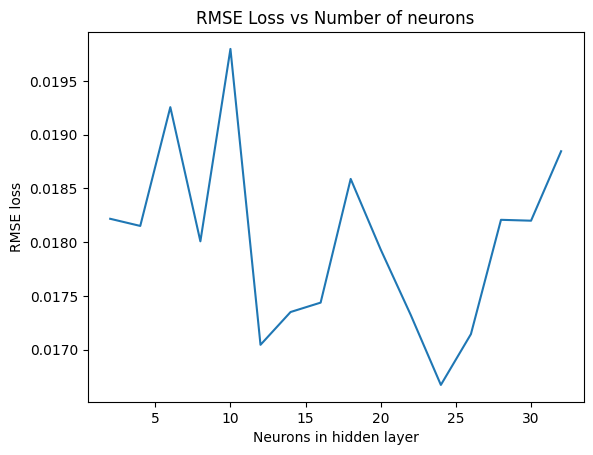

In [176]:
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
plt.plot(neurons_list, RMSE)
plt.title('RMSE Loss vs Number of neurons')
plt.ylabel('RMSE loss')
plt.xlabel('Neurons in hidden layer')
# plt.legend( loc=(1.02,0.85))
min_RMSE_neurons = neurons_list[RMSE.index(min(RMSE))]
min_RMSE_neurons

24

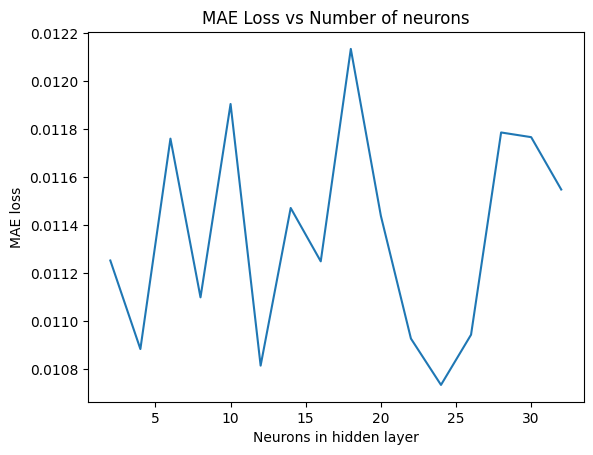

In [178]:
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
plt.plot(neurons_list, mae)
plt.title('MAE Loss vs Number of neurons')
plt.ylabel('MAE loss')
plt.xlabel('Neurons in hidden layer')
# plt.legend( loc=(1.02,0.85))
min_MAE_neurons = neurons_list[mae.index(min(mae))]
min_MAE_neurons

24

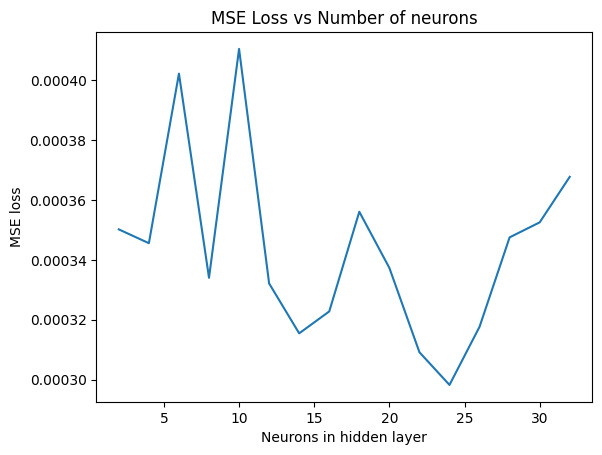

In [179]:
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
plt.plot(neurons_list, mse)
plt.title('MSE Loss vs Number of neurons')
plt.ylabel('MSE loss')
plt.xlabel('Neurons in hidden layer')
# plt.legend( loc=(1.02,0.85))
min_MSE_neurons = neurons_list[mse.index(min(mse))]
min_MSE_neurons

12

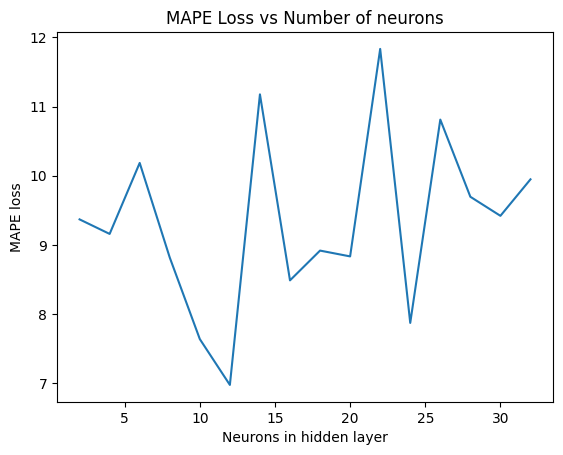

In [180]:
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
plt.plot(neurons_list, mape)
plt.title('MAPE Loss vs Number of neurons')
plt.ylabel('MAPE loss')
plt.xlabel('Neurons in hidden layer')
# plt.legend( loc=(1.02,0.85))
min_MAPE_neurons = neurons_list[mape.index(min(mape))]
min_MAPE_neurons

In [216]:
neurons = 24
activation = 'tanh'
loss_func = 'mean_absolute_error'
epoch = 200
batch_size = 16
validation_split = 0.2

In [217]:
model, scaler, loss, history, cl_train, cd_train, cl_test, cd_test = ANN_model(X, y, neurons ,activation, loss_func, epoch, batch_size, validation_split)

Epoch 1/200
10/10 [==============================] - 1s 34ms/step - loss: 0.4888 - mse: 0.2988 - rmse: 0.5466 - mape: 1147.1858 - val_loss: 0.3000 - val_mse: 0.0550 - val_rmse: 0.2345 - val_mape: 1121.6410
Epoch 2/200
10/10 [==============================] - 0s 7ms/step - loss: 0.2528 - mse: 0.0358 - rmse: 0.1892 - mape: 827.5927 - val_loss: 0.2615 - val_mse: 0.0425 - val_rmse: 0.2063 - val_mape: 688.2753
Epoch 3/200
10/10 [==============================] - 0s 7ms/step - loss: 0.2022 - mse: 0.0205 - rmse: 0.1433 - mape: 495.5960 - val_loss: 0.1797 - val_mse: 0.0127 - val_rmse: 0.1126 - val_mape: 471.5013
Epoch 4/200
10/10 [==============================] - 0s 7ms/step - loss: 0.1759 - mse: 0.0136 - rmse: 0.1167 - mape: 464.4375 - val_loss: 0.1468 - val_mse: 0.0078 - val_rmse: 0.0883 - val_mape: 395.2328
Epoch 5/200
10/10 [==============================] - 0s 7ms/step - loss: 0.1463 - mse: 0.0089 - rmse: 0.0942 - mape: 358.3871 - val_loss: 0.1391 - val_mse: 0.0072 - val_rmse: 0.0849 - v

In [218]:
loss

[0.012468486092984676,
 0.00047168604214675725,
 0.021718334406614304,
 4.621340274810791]

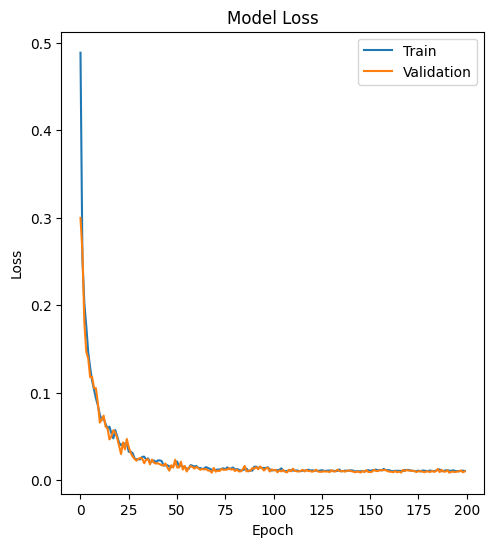

In [219]:
Validation_curves(history)

In [220]:
print (cl_train, cd_train, cl_test, cd_test)

3.379180014166697 5.40743118238441 3.9785625853461903 5.264117486911367


In [221]:
# joblib.dump(model, 'model__24_rmse.joblib')
# joblib.dump(scaler, 'scaler_file__24_rmse.joblib')

['scaler_file__24_rmse.joblib']

In [233]:
neurons = 12
model, scaler, loss, history, cl_train, cd_train, cl_test, cd_test = ANN_model(X, y, neurons ,activation, loss_func, epoch, batch_size, validation_split)

Epoch 1/200
10/10 [==============================] - 1s 35ms/step - loss: 0.5584 - mse: 0.2963 - rmse: 0.5444 - mape: 2325.9741 - val_loss: 0.4270 - val_mse: 0.1525 - val_rmse: 0.3905 - val_mape: 1540.8022
Epoch 2/200
10/10 [==============================] - 0s 7ms/step - loss: 0.3190 - mse: 0.0793 - rmse: 0.2815 - mape: 993.6710 - val_loss: 0.2613 - val_mse: 0.0420 - val_rmse: 0.2050 - val_mape: 830.9497
Epoch 3/200
10/10 [==============================] - 0s 7ms/step - loss: 0.2026 - mse: 0.0236 - rmse: 0.1536 - mape: 710.0226 - val_loss: 0.1765 - val_mse: 0.0147 - val_rmse: 0.1214 - val_mape: 619.4200
Epoch 4/200
10/10 [==============================] - 0s 7ms/step - loss: 0.1594 - mse: 0.0128 - rmse: 0.1131 - mape: 513.4583 - val_loss: 0.1443 - val_mse: 0.0107 - val_rmse: 0.1036 - val_mape: 539.4586
Epoch 5/200
10/10 [==============================] - 0s 6ms/step - loss: 0.1285 - mse: 0.0081 - rmse: 0.0902 - mape: 438.2764 - val_loss: 0.1131 - val_mse: 0.0056 - val_rmse: 0.0751 - v

In [234]:
loss

[0.011567124165594578,
 0.0004452780121937394,
 0.021101610735058784,
 4.9336771965026855]

In [235]:
print (cl_train, cd_train, cl_test, cd_test)

2.8797760764677953 5.626134430781212 3.6319320984875603 6.235421593635727


In [236]:
# joblib.dump(model, 'model__12_rmse.joblib')
# joblib.dump(scaler, 'scaler_file__12_rmse.joblib')

['scaler_file__12_rmse.joblib']